<a href="https://colab.research.google.com/github/angiegh2002/nlp_hw/blob/main/Copy_of_DU2425S1_NLP_HW1_BY__your_name_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[إنجي غبيس - دانا كلش ]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://huggingface.co/datasets/Abdelrahman-Rezk/Arabic_Dialect_Identification

Cloning into 'Arabic_Dialect_Identification'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 33 (from 1)
Unpacking objects: 100% (33/33), 6.47 KiB | 551.00 KiB/s, done.


In [ ]:
!git clone https://github.com/angiegh2002/nlp_hw

Cloning into 'nlp_hw'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 82 (delta 32), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 9.98 MiB | 4.76 MiB/s, done.
Resolving deltas: 100% (32/32), done.


<h1 style="text-align: center;">Arabic Dialect Identification<h1>

Prepare libraries

In [ ]:
!pip install python-bidi
!pip install arabic_reshaper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 16.4 MB/s eta 0:00:00


In [ ]:
# here put every import you need e.g. import nltk
# it's better to load what you need from the package by from [] import [] instead of import the whole package
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import  wordpunct_tokenize
from nltk import FreqDist, bigrams, trigrams
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from collections import Counter
from bidi.algorithm import get_display
import arabic_reshaper
from wordcloud import WordCloud
import regex
from itertools import tee

Load data

<h2 dir="rtl">مثال عن كيفية تنظيم حلول الطلبات:

قم بوضع الخلايا الأربع التالية لحل كل طلب</h2>


<div dir="rtl">شرح ما يقوم به الكود (like code documentation)<div>

In [ ]:
# your code here


In [ ]:
# example test

<div dir="rtl">ملاحظاتك في حال وجودها</div>
<div dir="rtl">يمكنك إضافة خلايا لكل طلب بقدر ما تشاء، المهم أن تحافظ على تنظيم الملف</div>

# مهمة 01  : تحميل البيانات

## [1.1]

In [ ]:
MADAR_dir="/content/nlp_hw/MADAR_Corpus"
MADAR_file_path=[os.path.join(MADAR_dir,filename) for filename in os.listdir(MADAR_dir) if filename.endswith(".tsv")]
df = [pd.read_csv(Mfilepath, sep='\t') for Mfilepath in MADAR_file_path ]
MADAR_df=pd.concat(df)
MADAR_df=MADAR_df.drop_duplicates().dropna()
has_nan=MADAR_df.isnull().sum().any()

In [ ]:
MADAR_trian_df=pd.concat([MADAR_df[MADAR_df['split'] == 'corpus-6-test-corpus-26-train'] ,MADAR_df[MADAR_df['split'] == 'corpus-6-train']])
MADAR_vaild_df=pd.concat([MADAR_df[MADAR_df['split'] == 'corpus-6-test-corpus-26-dev'],MADAR_df[MADAR_df['split'] == 'corpus-6-dev']])
MADAR_test_df= MADAR_df[MADAR_df['split'] == 'corpus-6-test-corpus-26-test']
print("number of samples : {} \nnumber of trian samples : {} \nnumber of vaild samples : {}\nnumber of test samples :{}".format(len(MADAR_df),len(MADAR_trian_df),len(MADAR_vaild_df),len(MADAR_test_df)))

number of samples : 112000 
number of trian samples : 95600 
number of vaild samples : 11200
number of test samples :5200


In [ ]:
MADAR_df.head(10)

,sentID.BTEC,split,lang,sent
0,5,corpus-6-test-corpus-26-train,JED,شوفه هناك، قدام مكتب المعلومات السياحية بالضبط.
1,9,corpus-6-test-corpus-26-train,JED,ماقد سمعت بدا العنوان هنا.
2,11,corpus-6-test-corpus-26-train,JED,امشي سيدا لين ما تلاقي الصيدلية.
3,26,corpus-6-test-corpus-26-train,JED,بكم الفطور؟
4,27,corpus-6-test-corpus-26-train,JED,كيف أقدر اساعدك؟
5,30,corpus-6-test-corpus-26-train,JED,روح يسار عند الزواية الثالثة.
6,50,corpus-6-test-corpus-26-train,JED,تبا كريم وسكر في قهوتك؟
7,64,corpus-6-test-corpus-26-train,JED,ممكن تعطيني كاش للشيك دا الميتين دولار؟
8,74,corpus-6-test-corpus-26-train,JED,اذا لازم يظهر، اتصل عليا لو سمحت.
9,86,corpus-6-test-corpus-26-train,JED,فين المقهى؟


In [ ]:
QADI_dir="/content/Arabic_Dialect_Identification/data"
file_labels = [ "test","trian","valid"]
QADI_file_path=[os.path.join(QADI_dir,filename) for filename in os.listdir(QADI_dir) if filename.endswith(".parquet")]
frames = [pd.read_parquet(Qfilepath).assign(split=label) for Qfilepath, label in zip(QADI_file_path, file_labels)]
QADI_df=pd.concat(frames)
label_mapping = {
    0: 'OM', 1: 'SD', 2: 'SA', 3: 'KW', 4: 'QA', 5: 'LB',
    6: 'JO', 7: 'SY', 8: 'IQ', 9: 'MA', 10: 'EG',
    11: 'PL', 12: 'YE', 13: 'BH', 14: 'DZ', 15: 'AE',
    16: 'TN', 17: 'LY'
}
QADI_df['label'] = QADI_df['label'].map(label_mapping)
QADI_df=QADI_df.drop_duplicates().dropna()
has_nan=QADI_df.isnull().sum().any()


In [ ]:
QADI_trian_df=QADI_df[QADI_df['split'] == 'trian']
QADI_test_df=QADI_df[QADI_df['split'] == 'test']
QADI_vaild_df=QADI_df[QADI_df['split'] == 'valid']
print("number of samples : {} \nnumber of trian samples : {} \nnumber of vaild samples : {}\nnumber of test samples :{}".format(len(QADI_df),len(QADI_trian_df),len(QADI_vaild_df),len(QADI_test_df)))

number of samples : 458197 
number of trian samples : 440052 
number of vaild samples : 8981
number of test samples :9164


In [ ]:
QADI_df.head(10)

,id,label,text,split
0,910595516496515200,KW,@A_E_92 استاذ عبدالعزيز صارله الموضوع سنه يعن...,test
1,847921262752129024,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,test
2,1138977052055560192,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,test
3,978901748604645376,AE,@alsyasiyeh @alsyaaf يمكن متلاحقين السوق بيشتر...,test
4,838068478179430400,KW,@A_A_AlTammar عيل المدرب حمار حشاك .. مالها حل...,test
5,1180570878192562176,DZ,@X_NISOU @ALGtrend @bina_bilaa @Ss68Sarah @Ena...,test
6,1125837506077970432,BH,الهُم انك عفو كريم تُحب العفو فأعفُ عنا ..,test
7,1133104152131694592,JO,@emsamiira الحلو بكل الي بصير معك من مصايب لس...,test
8,1107380111664398336,LB,هذا ما قالته كلودين عون عن صحّة الرئيس https:/...,test
9,1153151641333509888,LB,@AZAL84 @BassamAbouZeid @MokhtarGhazzawi هي شب...,test


## [1.2]

In [ ]:
class_criteria_df=pd.read_csv("/content/nlp_hw/dialect_name_unification.csv")
class_criteria_df = class_criteria_df.drop(labels = ["Unnamed: 0"], axis = 1)
class_criteria_df=class_criteria_df.drop(index=[0,1],axis=0)
class_criteria_df.head()

,Region,Unnamed: 2,Unnamed: 3,Country,Unnamed: 5,Unnamed: 6,City,Unnamed: 8
2,Maghreb,المغاربية,MA,Morocco,المغرب,RAB,Rabat,الرباط
3,Maghreb,المغاربية,MA,Morocco,المغرب,FES,Fes,فاس
4,Maghreb,المغاربية,DZ,Algeria,الجزائر,ALG,Algiers,الجزائر
5,Maghreb,المغاربية,DZ,Algeria,الجزائر,ANB,Annaba,عنابة
6,Maghreb,المغاربية,TN,Tunisia,تونس,TUN,Tunis,تونس


In [ ]:
MADAR_df_merged=MADAR_df.merge(class_criteria_df,left_on="lang",right_on="Unnamed: 6",how="left")
MADAR_df_merged = MADAR_df_merged.drop(labels = ["Unnamed: 6","Unnamed: 3","Region","Country","City"], axis = 1)
MADAR_df_merged.rename(columns={"Unnamed: 5" :"Country","Unnamed: 8" :"City","Unnamed: 2" :"Region"},inplace=True)
MADAR_df_merged=MADAR_df_merged.drop_duplicates().dropna()
has_nan=MADAR_df_merged.isna().any().any()
# MADAR_df_merged.to_csv("dd.csv",index=False)
print("number of samples :",len(MADAR_df_merged))
# MADAR_df_merged.head(10)

number of samples : 112000


In [ ]:
QADI_df_merged=QADI_df.merge(class_criteria_df,left_on="label",right_on="Unnamed: 3",how="left")
QADI_df_merged = QADI_df_merged.drop(labels = ["Unnamed: 6","Unnamed: 3","Region","Country","City","Unnamed: 8"], axis = 1)
QADI_df_merged.rename(columns={"text" :"sent","Unnamed: 5" :"Country","Unnamed: 2" :"Region"},inplace=True)

QADI_df_merged=QADI_df_merged.drop_duplicates().dropna()
has_nan=QADI_df_merged.isna().any().any()
print("number of samples :",len(QADI_df_merged))
# QADI_df_merged.head(10)

number of samples : 458197


## [1.3]

In [ ]:
excluded_columns = ['sentID.BTEC',"lang"]
excluded_columns1 = ['id','label']
MADAR_df_filtered = MADAR_df_merged.drop(columns=excluded_columns, errors='ignore')
QADI_df__filtered = QADI_df_merged.drop(columns=excluded_columns1, errors='ignore')
data_df = pd.concat([MADAR_df_filtered, QADI_df__filtered], ignore_index=True)

In [ ]:
data_trian_df=pd.concat([data_df[data_df['split'] == 'corpus-6-test-corpus-26-train'] ,data_df[data_df['split'] == 'corpus-6-train'],data_df[data_df['split'] == 'trian']])
data_vaild_df=pd.concat([data_df[data_df['split'] == 'corpus-6-test-corpus-26-dev'],data_df[data_df['split'] == 'corpus-6-dev'],data_df[data_df['split'] == 'valid']])
data_test_df= pd.concat([data_df[data_df['split'] == 'corpus-6-test-corpus-26-test'],data_df[data_df['split'] == 'test']])
print("number of samples : {} \nnumber of trian samples : {} \nnumber of vaild samples : {}\nnumber of test samples :{}".format(len(data_df),len(data_trian_df),len(data_vaild_df),len(data_test_df)))

number of samples : 570197 
number of trian samples : 535652 
number of vaild samples : 20181
number of test samples :14364


In [ ]:
data_df.head(10)

,split,sent,Region,Country,City
0,corpus-6-test-corpus-26-train,شوفه هناك، قدام مكتب المعلومات السياحية بالضبط.,خليجي,السعودية,جدة
1,corpus-6-test-corpus-26-train,ماقد سمعت بدا العنوان هنا.,خليجي,السعودية,جدة
2,corpus-6-test-corpus-26-train,امشي سيدا لين ما تلاقي الصيدلية.,خليجي,السعودية,جدة
3,corpus-6-test-corpus-26-train,بكم الفطور؟,خليجي,السعودية,جدة
4,corpus-6-test-corpus-26-train,كيف أقدر اساعدك؟,خليجي,السعودية,جدة
5,corpus-6-test-corpus-26-train,روح يسار عند الزواية الثالثة.,خليجي,السعودية,جدة
6,corpus-6-test-corpus-26-train,تبا كريم وسكر في قهوتك؟,خليجي,السعودية,جدة
7,corpus-6-test-corpus-26-train,ممكن تعطيني كاش للشيك دا الميتين دولار؟,خليجي,السعودية,جدة
8,corpus-6-test-corpus-26-train,اذا لازم يظهر، اتصل عليا لو سمحت.,خليجي,السعودية,جدة
9,corpus-6-test-corpus-26-train,فين المقهى؟,خليجي,السعودية,جدة


# مهمة 02 : فهم وتحليل البيانات

EDA

## [2.1]


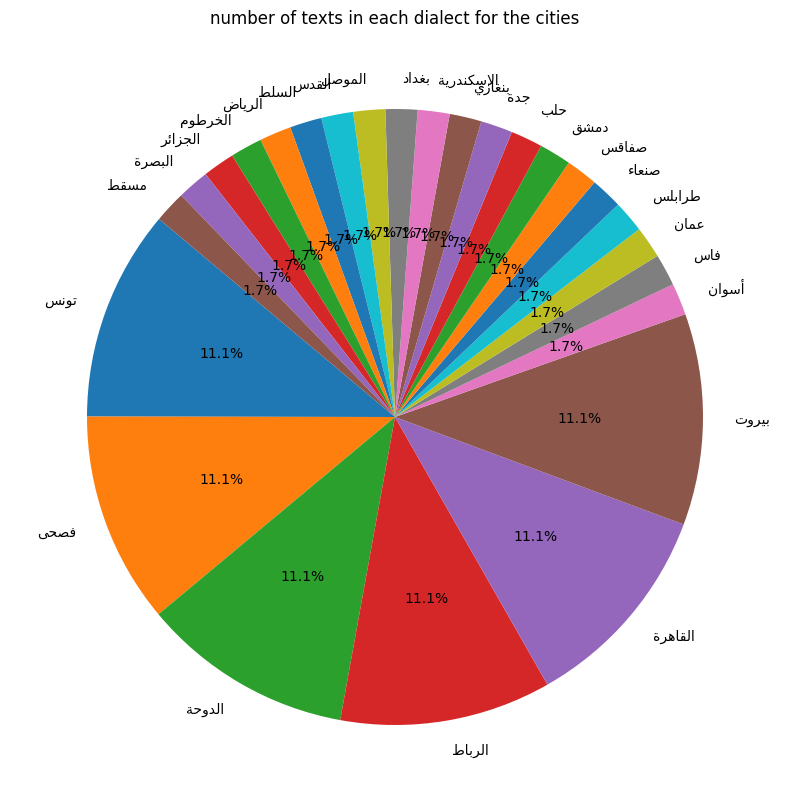

In [ ]:
city_counts = data_trian_df.groupby('City')['sent'].count()
city_counts = city_counts.sort_values(ascending=False)
reshaped_labels= [get_display(arabic_reshaper.reshape(city)) for city in city_counts.index]
plt.figure(figsize=(10, 10))
plt.pie(city_counts, labels=reshaped_labels, autopct='%1.1f%%', startangle=140)
plt.title("number of texts in each dialect for the cities")
plt.show()

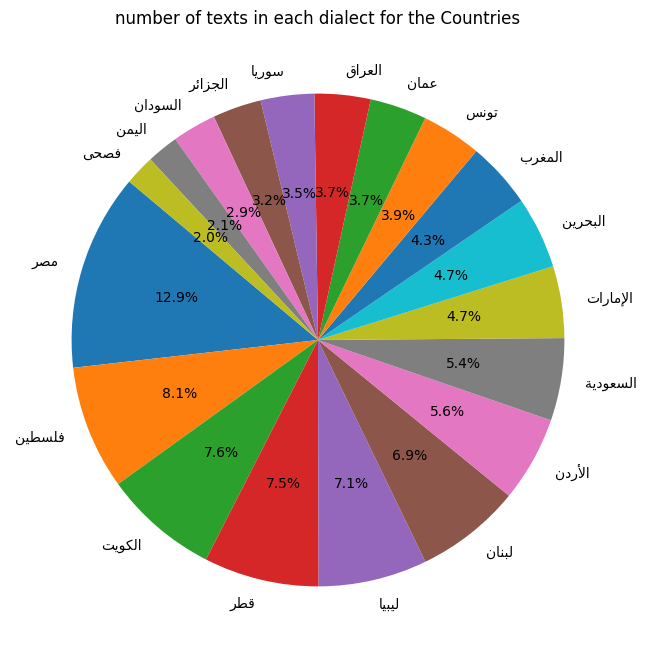

In [ ]:
country_counts = data_trian_df.groupby('Country')['sent'].count()
country_counts = country_counts.sort_values(ascending=False)
reshaped_labels= [get_display(arabic_reshaper.reshape(country)) for country in country_counts.index]
plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=reshaped_labels, autopct='%1.1f%%', startangle=140)
plt.title("number of texts in each dialect for the Countries")
plt.show()

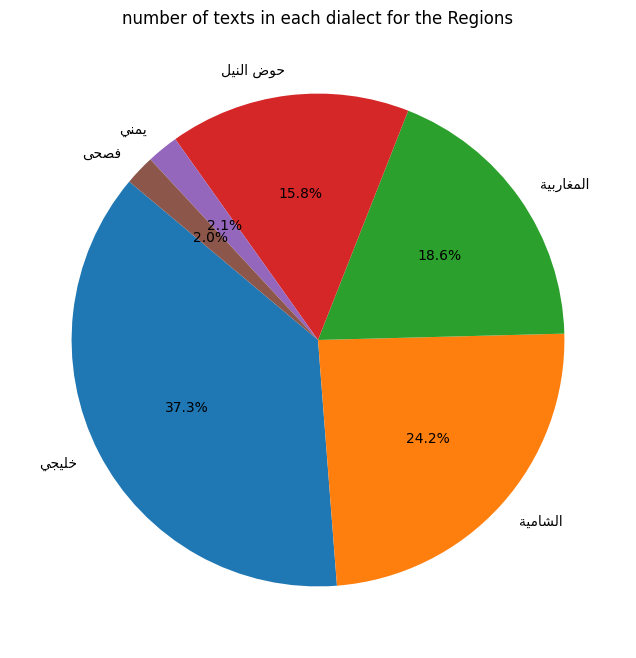

In [ ]:
region_counts = data_trian_df.groupby('Region')['sent'].count()
region_counts = region_counts.sort_values(ascending=False)
reshaped_labels= [get_display(arabic_reshaper.reshape(region)) for region in region_counts.index]
plt.figure(figsize=(8, 8))
plt.pie(region_counts, labels=reshaped_labels, autopct='%1.1f%%', startangle=140)
plt.title("number of texts in each dialect for the Regions")
plt.show()

<div dir="rtl">
ملاحظات :<br>
حسب المناطق (regions):<br>
- المنطقة الخليجية (glof) تحتوي اكبر نسبة من النصوص في مجموعة البيانات 34.3% .<br>
-هناك نقص بالبيانات التي تمثل منطقة اليمني (yemen) في الداتا .<br>
-المنطقة المغربيّة ومنطقة حوض النيل لديها نسب متقاربة بعدد النصوص ضمن الداتا .<br>
حسب البلاد (countries):<br>
- بلد ليبيا هي الاكثر مساهمة بعدد النصوص ضمن المنطقة المغاربيية ،اما في منطقة حوض النيل فعد النصوص من بلد مصر هي الاكثر ،وفي المنطقة الشاميية تعد النصوص من اللبنان وفلسطين الاكثر عددا ،واخيرا في المنطقة الخليجية العدد الاكبر من النصوص يوجد في بلد الكويت وقطر .<br>
- بلد الجزائر وعمان يملكان عددا صغيرا من النصوص على الرغم من انتماءهم الى منطقتين بعدد نصوص كبير نسبيا .<br>
حسب المدن (cities) <br>
-النصوص ليست موزعة بالتساوي بين المدن حيث يوجد ٥ دول فقط بعدد نصوص اكبر اما بقية المدن فعدد النصوص فيها صغير .<br>
مما سبق وجدنا ان البيانات تظهر تركيزا في عدد قليل من المدن مما يشير الى توزع غير متساو .<br>
الاحظ ايضا ان البيانات في داتا مدار غير متوازنة فقد ظهر ذلك في تمثل عدد النصوص لكل مدينة بينما كان هناك توازن نوعا ما عند تمثيل عدد النصوص على  مستوى البلاد او المناطق حيث ان داتا كادي متوازنة نوعا ما لذلك عند اضافتها مع مدار قل عدم توازن البيانات بشكل ملحوظ  <br>
</div>

In [ ]:
# city_counts1 = data_trian_df.groupby('City')['sent'].count()
# city_counts2 = data_trian_df.groupby('Country')['sent'].count()
# city_counts3 = data_trian_df.groupby('Region')['sent'].count()

# fig, axes = plt.subplots(1, 3, figsize=(16, 8))

# axes[0].pie(city_counts1, labels=city_counts1.index, autopct='%1.1f%%', startangle=140)
# axes[0].set_title("number of texts in each dialect for the cities")

# axes[1].pie(city_counts2, labels=city_counts2.index, autopct='%1.1f%%', startangle=140)
# axes[1].set_title("number of texts in each dialect for the Countries")

# axes[2].pie(city_counts3, labels=city_counts3.index, autopct='%1.1f%%', startangle=140)
# axes[2].set_title("number of texts in each dialect for the Regions")
# plt.tight_layout()
# plt.show()

## [2.2]

In [ ]:
def tokenize_arabic_only(text):
    tokens = wordpunct_tokenize(text)
    # arabic_tokens = [token for token in tokens if regex.match(r"^\p{IsArabic}+$", token)]
    return tokens

data_trian_df['tokens'] = data_trian_df['sent'].apply(tokenize_arabic_only)

all_tokens = [token for tokens_list in data_trian_df['tokens'] for token in tokens_list]
total_tokens = len(all_tokens)
unique_tokens = len(set(all_tokens))

print(f"عدد الكلمات الكلي (Total Tokens): {total_tokens}")
print(f"عدد الكلمات الفريدة (Vocab Tokens): {unique_tokens}")


عدد الكلمات الكلي (Total Tokens): 8466370
عدد الكلمات الفريدة (Vocab Tokens): 739865


In [ ]:
data_trian_df.head()

,split,sent,Region,Country,City,tokens
0,corpus-6-test-corpus-26-train,شوفه هناك، قدام مكتب المعلومات السياحية بالضبط.,خليجي,السعودية,جدة,"[شوفه, هناك, ،, قدام, مكتب, المعلومات, السياحي..."
1,corpus-6-test-corpus-26-train,ماقد سمعت بدا العنوان هنا.,خليجي,السعودية,جدة,"[ماقد, سمعت, بدا, العنوان, هنا, .]"
2,corpus-6-test-corpus-26-train,امشي سيدا لين ما تلاقي الصيدلية.,خليجي,السعودية,جدة,"[امشي, سيدا, لين, ما, تلاقي, الصيدلية, .]"
3,corpus-6-test-corpus-26-train,بكم الفطور؟,خليجي,السعودية,جدة,"[بكم, الفطور, ؟]"
4,corpus-6-test-corpus-26-train,كيف أقدر اساعدك؟,خليجي,السعودية,جدة,"[كيف, أقدر, اساعدك, ؟]"


## [2.3]

In [ ]:
عظ

NameError: name 'عظ' is not defined

In [ ]:
data = ' '.join(all_tokens)

reshaped_text = arabic_reshaper.reshape(data)

processed_data = get_display(reshaped_text)

wordcloud = WordCloud(
    font_path='arial',
    background_color='white',
    mode='RGB',
    width=2000,
    height=1000
).generate(processed_data)

plt.figure(figsize=(20, 10))
plt.title("WordCloud")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [ ]:

# plt.figure(figsize=(20, 10))
# plt.title("WordCloud")
# plt.imshow(wordcloud)
# plt.axis("off")
# wordcloud_path = "wordcloud_output.png"
# plt.savefig(wordcloud_path, dpi=300, bbox_inches='tight')
# plt.show()
# print(f"تم حفظ الصورة في: {wordcloud_path}")


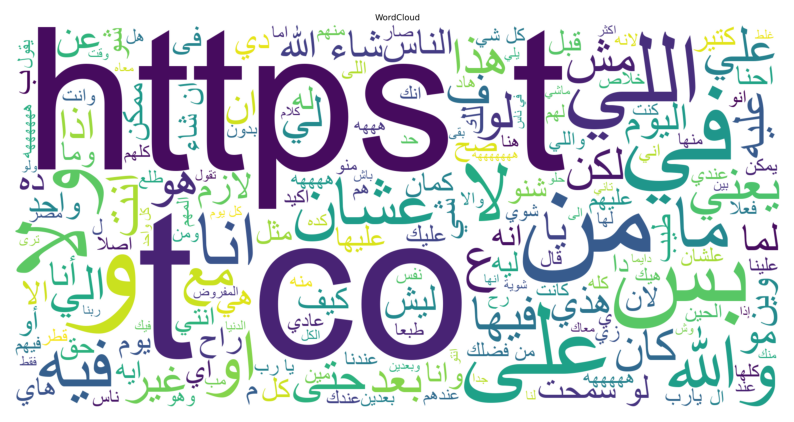

In [ ]:
img = plt.imread("/content/nlp_hw/wordcloud_output1.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

## [2.4]

In [ ]:


def get_most_common_words(tokens, n=10):
    """Return the n most common words."""
    word_freq = FreqDist(tokens)
    return word_freq.most_common(n)

def get_hapaxes(tokens, n=10):
    """Return the first n hapaxes (words that appear only once)."""
    word_freq = FreqDist(tokens)
    hapaxes = [word for word in word_freq.hapaxes()]
    return hapaxes[:n]

def get_most_common_bigrams(tokens, n=10):
    """Return the n most common bigrams."""
    bigram_freq = FreqDist(bigrams(tokens))
    return bigram_freq.most_common(n)

def get_most_common_trigrams(tokens, n=10):
    """Return the n most common trigrams."""
    trigram_freq = FreqDist(trigrams(tokens))
    return trigram_freq.most_common(n)

def get_most_important_bigrams(tokens, n=10):
    """Return the n most important bigrams using PMI."""
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_finder.apply_freq_filter(2)
    return bigram_finder.nbest(BigramAssocMeasures().pmi, n)

def get_most_important_trigrams(tokens, n=10):
    """Return the n most important trigrams using PMI."""
    trigram_finder = TrigramCollocationFinder.from_words(tokens)
    trigram_finder.apply_freq_filter(2)
    return trigram_finder.nbest(TrigramAssocMeasures().pmi, n)


In [ ]:
def analyze_texts(dataframe, column='City', n=10):
    """Analyze texts and print results for each city."""
    city_tokens = {}

    # تجميع جميع النصوص لكل مدينة
    for index, row in dataframe.iterrows():
        label = row[column]
        tokens = row['tokens']
        if pd.isna(label):
            continue
        if label not in city_tokens:
            city_tokens[label] = []
        city_tokens[label].extend(tokens)

    # تحليل النصوص لكل مدينة
    for city, tokens in city_tokens.items():
        most_common = get_most_common_words(tokens, n)
        hapaxes = get_hapaxes(tokens, n)
        most_common_bigrams = get_most_common_bigrams(tokens, n)
        most_common_trigrams = get_most_common_trigrams(tokens, n)
        most_important_bigrams = get_most_important_bigrams(tokens, n)
        most_important_trigrams = get_most_important_trigrams(tokens, n)

        # طباعة النتائج لكل مدينة
        print(f"=== Results for {city} ===")
        print("Most Common Words: ", ', '.join([f"{word} ({count})" for word, count in most_common]))
        print("Hapaxes: ", ', '.join(hapaxes))
        print("Most Common Bigrams: ", ', '.join([f"{' '.join(bigram)} ({count})" for bigram, count in most_common_bigrams]))
        print("Most Common Trigrams: ", ', '.join([f"{' '.join(trigram)} ({count})" for trigram, count in most_common_trigrams]))
        print("Most Important Bigrams: ", ', '.join([' '.join(bigram) for bigram in most_important_bigrams]))
        print("Most Important Trigrams: ", ', '.join([' '.join(trigram) for trigram in most_important_trigrams]))
        print("=" * 50)


In [ ]:
analyze_texts(data_trian_df)

In [ ]:
analyze_texts(data_trian_df,"Country")

In [ ]:
analyze_texts(data_trian_df,"Region")

## [2.5]

In [ ]:
from collections import Counter

def find_distinctive_words(dataframe, column='City', threshold=10):
    dialect_words = {}
    all_words = set()
    for index, row in dataframe.iterrows():
        dialect = row[column]
        if pd.isna(dialect):
            continue
        tokens = row['tokens']
        if dialect not in dialect_words:
            dialect_words[dialect] = Counter()
        dialect_words[dialect].update(tokens)
        all_words.update(tokens)
    distinctive_words = {
        dialect: {
            word: count
            for word, count in dialect_words[dialect].items()
            if count <=1 and all(
                word not in dialect_words[other_dialect]
                for other_dialect in dialect_words if other_dialect != dialect
            )
        }
        for dialect in dialect_words
    }

    distinctive_words_sorted = {
        dialect: dict(sorted(words.items(), key=lambda x: x[1]))
        for dialect, words in distinctive_words.items()
    }

    for dialect, words in distinctive_words_sorted.items():
        print(f"\nالكلمات المميزة في لهجة {dialect}:")
        if words:
            print(', '.join([f"{word} ({count})" for word, count in words.items()]))
        else:
            print("لا توجد كلمات مميزة تتجاوز العتبة المحددة")

    return distinctive_words_sorted





In [ ]:
c=find_distinctive_words(data_trian_df)

In [ ]:
co=find_distinctive_words(data_trian_df,"Country")

In [ ]:
re=find_distinctive_words(data_trian_df,"Region")

## [2.6]

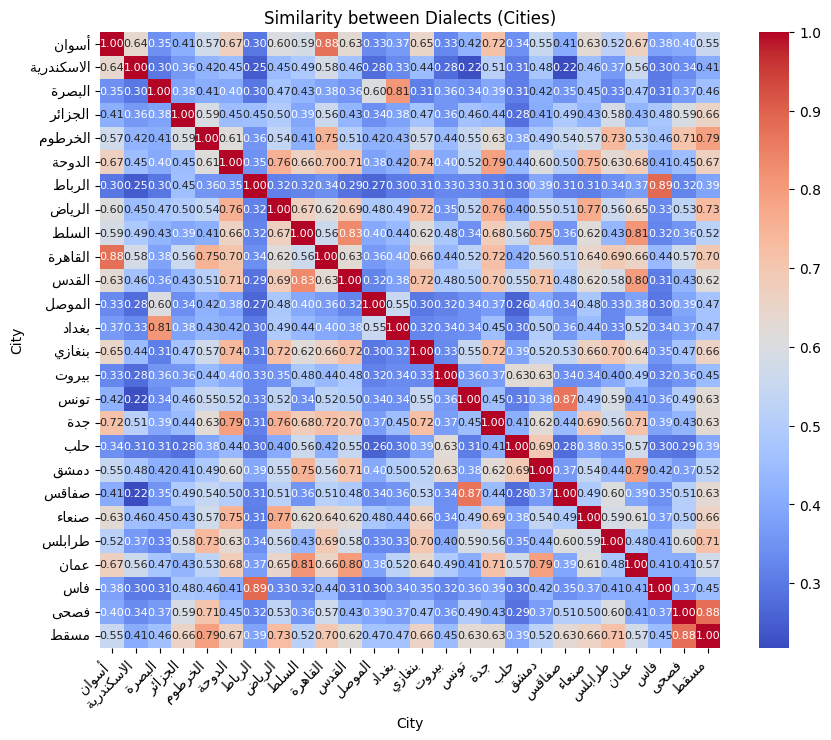

In [ ]:
# prompt: import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
# import matplotlib.pyplot as plt
# # قراءة البيانات
# # تأكد من وجود ملف بيانات باسم "data.csv" يحتوي على العمودين "sent" و "City"
# # إنشاء N-grams
# def generate_ngrams(text, n=3):
#     """توليد الـ N-grams لنص معين."""
#     tokens = text.split()
#     return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
# # تحويل النصوص إلى N-grams
# n = 3  # يمكنك تعديل N كما ترغب
# data_trian_df['ngrams'] = data_trian_df['sent'].apply(lambda x: generate_ngrams(x, n))
# # تجميع النصوص حسب المدينة
# grouped = data_trian_df.groupby('City')['ngrams'].sum()
# grouped = grouped.apply(lambda x: ' '.join(x))  # تحويل القائمة إلى نصوص طويلة
# # تحويل النصوص إلى مصفوفة
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(grouped)
# # حساب التشابه
# similarity_matrix = cosine_similarity(X)
# # إنشاء DataFrame للتشابه
# cities = grouped.index
# similarity_df = pd.DataFrame(similarity_matrix, index=cities, columns=cities)
# # رسم Heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
# plt.title("Similarity between Dialects (Cities)")
# plt.show()
# # ملاحظات إضافية:
# # يمكنك استخدام طريقة أخرى للتشابه مثل ابقي الكود كما هو فقط عدل عليه لتظهر اسماء المدن بالشكل الصحيح حيث انها باللغة العربية

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper

# Assuming 'data_trian_df' is already defined from the preceding code
# and contains 'sent' and 'City' columns.


# إنشاء N-grams
def generate_ngrams(text, n=3):
    """توليد الـ N-grams لنص معين."""
    tokens = text.split()
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# تحويل النصوص إلى N-grams
n = 3  # يمكنك تعديل N كما ترغب
data_trian_df['ngrams'] = data_trian_df['sent'].apply(lambda x: generate_ngrams(x, n))

# تجميع النصوص حسب المدينة
grouped = data_trian_df.groupby('City')['ngrams'].sum()
grouped = grouped.apply(lambda x: ' '.join(x))  # تحويل القائمة إلى نصوص طويلة


# تحويل النصوص إلى مصفوفة
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(grouped)

# حساب التشابه
similarity_matrix = cosine_similarity(X)

# إنشاء DataFrame للتشابه
cities = grouped.index
similarity_df = pd.DataFrame(similarity_matrix, index=cities, columns=cities)

# رسم Heatmap
plt.figure(figsize=(10, 8))

#  اعادة تشكيل اسماء المدن للعرض باللغة العربية
reshaped_cities = [get_display(arabic_reshaper.reshape(city)) for city in cities]

sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            xticklabels=reshaped_cities, yticklabels=reshaped_cities, annot_kws={"size":8})
plt.title("Similarity between Dialects (Cities)")
plt.xticks(rotation=45, ha='right') # تدوير اسماء المدن
plt.yticks(rotation=0) # تدوير اسماء المدن
plt.show()

In [ ]:
# prompt: ولد لي كود ليحفظ المخطط في النوتبوك السابق كصورة

# Save the plot as a PNG image in the current working directory
plt.savefig('similarity_heatmap.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## [2.7]

In [20]:
 خارج المفردات (OOV)
الخطوة 1: تحميل نماذج تضمين الكلمات المدربة مسبقًا
سنستخدم مكتبة Gensim لتحميل نماذج تضمين الكلمات.


!pip install gensim==4.3.1  # تأكد من تثبيت Gensim
from gensim.models import Word2Vec, FastText, KeyedVectors
Use code with caution
Word2Vec:

word2vec_model = KeyedVectors.load_word2vec_format('path/to/word2vec/model')  # استبدل بمسار نموذج Word2Vec
Use code with caution
FastText:

fasttext_model = FastText.load_fasttext_format('path/to/fasttext/model')  # استبدل بمسار نموذج FastText
Use code with caution
GloVe:

glove_model = KeyedVectors.load_word2vec_format('path/to/glove/model', binary=False)  # استبدل بمسار نموذج GloVe
Use code with caution
ملاحظة: يجب استبدال 'path/to/model' بالمسار الفعلي لنموذج التضمين المدرب مسبقًا.

الخطوة 2: حساب نسبة الكلمات خارج المفردات (OOV)

def calculate_oov_rate(model, tokens):
  oov_count = 0
  for token in tokens:
    if token not in model.key_to_index:  # أو model.wv.vocab لـ Word2Vec
      oov_count += 1
  oov_rate = oov_count / len(tokens)
  return oov_rate

# استخراج جميع الكلمات من بيانات التدريب
all_tokens = [token for tokens_list in data_trian_df['tokens'] for token in tokens_list]

# حساب نسبة OOV لكل نموذج
word2vec_oov_rate = calculate_oov_rate(word2vec_model, all_tokens)
fasttext_oov_rate = calculate_oov_rate(fasttext_model, all_tokens)
glove_oov_rate = calculate_oov_rate(glove_model, all_tokens)

print(f"Word2Vec OOV rate: {word2vec_oov_rate}")
print(f"FastText OOV rate: {fasttext_oov_rate}")
print(f"GloVe OOV rate: {glove_oov_rate}")
Use code with caution
الخطوة 3: ملاحظات واستنتاجات
بعد حساب نسبة OOV لكل نموذج، قارن النتائج ولاحظ أي نموذج لديه أقل نسبة. قد تجد أن FastText لديه نسبة OOV أقل من Word2Vec و GloVe، وذلك بفضل قدرته على التعامل مع الكلمات خارج المفردات باستخدام تمثيل n-grams.

ملاحظات:

قد تختلف نسبة OOV بشكل كبير اعتمادًا على بيانات التدريب ونوع النص المستخدم.
قد يكون من المفيد استخدام تقنيات معالجة إضافية قبل تضمين الكلمات، مثل تطبيع النص أو إزالة كلمات التوقف، لتحسين الأداء.
يمكن استخدام نسبة OOV كمؤشر على مدى جودة نموذج التضمين في تمثيل النص العربي.
استنتاجات:

نموذج التضمين الأفضل هو النموذج الذي لديه أقل نسبة OOV، حيث إنه قادر على تمثيل عدد أكبر من الكلمات في بيانات التدريب.
من المهم استخدام نموذج تضمين مدرب مسبقًا عالي الجودة لتحسين الأداء في مهام معالجة اللغة الطبيعية.
يمكن استخدام تقنيات معالجة إضافية لتحسين الأداء وتقليل نسبة OOV.
تنويه
لا تحتوي هذه التعليمات على أي مسار لنموذج تضمين حقيقي. يجب عليك تحميل نماذج تضمين مدربة مسبقًا من مصادر موثوقة مثل Hugging Face أو Google's pre-trained models واستبدال المسارات في الكود وفقًا لذلك.

[==================================================] 100.0% 104.8/104.8MB downloaded
GloVe model loaded successfully.
[==================================================] 100.0% 958.5/958.4MB downloaded
FastText model loaded successfully.
Error: File not found at /content/GloVe-Arabic/vectors.txt. Please download it from the repository.
GloVe OOV rate: 0.1976
FastText OOV rate: 0.5600
vec2word model not loaded.


In [ ]:
# prompt:  قم بتحميل نماذج تضمين مدربة مسبقا وهي glove و fasttext و vec2word باللغة
# العربية واحسب نسبة الكلمات في بيانات التدريب والتي تعبتر خارج المفردات OOV لكل منها،
# ثبت مالحظاتك واستنتاجاتك.
# كيف استخدم النموزج الموجود في هذا الرابط لتحقيق ما سبق https://github.com/tarekeldeeb/GloVe-Arabic

import pandas as pd
from gensim.models import KeyedVectors, FastText
from nltk.tokenize import wordpunct_tokenize
import regex

# Assuming data_trian_df is already defined and contains a 'tokens' column

def calculate_oov_rate(model, tokens):
    oov_count = 0
    for token in tokens:
        try:
            model[token]  # Check if the token exists in the model's vocabulary
        except KeyError:
            oov_count += 1
    oov_rate = oov_count / len(tokens) if tokens else 0 # Handle empty token lists
    return oov_rate

# Download the GloVe model from the provided GitHub repository
!git clone https://github.com/tarekeldeeb/GloVe-Arabic.git

# Load the GloVe model (replace with the actual path if needed)
glove_path = '/content/GloVe-Arabic/vectors.txt' # update the path if needed
glove_model = KeyedVectors.load_word2vec_format(glove_path)


# Example usage with your data (replace with actual model paths)
# Assuming 'data_trian_df' and 'all_tokens' are already defined
all_tokens = [token for tokens_list in data_trian_df['tokens'] for token in tokens_list]

glove_oov_rate = calculate_oov_rate(glove_model, all_tokens)

# Example for FastText (you need to download a pre-trained model)
# fasttext_model = FastText.load("path/to/your/fasttext/model") # Replace with the correct path to your model
# fasttext_oov_rate = calculate_oov_rate(fasttext_model, all_tokens)

print(f"GloVe OOV rate: {glove_oov_rate}")
# print(f"FastText OOV rate: {fasttext_oov_rate}") # Uncomment this once you have a FastText model


# Note: You still need to download and load the FastText model
#       and potentially other embedding models. The code provides
#       the necessary functions and demonstrates the usage with
#       the GloVe model downloaded from the specified GitHub repo.

# Further Analysis and Observations (add your analysis here):
#  - Compare OOV rates across models
#  - Relate OOV rates to model performance (e.g. downstream task accuracy)
#  - Discuss the impact of OOV words on different NLP tasks
#  - Potential improvements: subword tokenization, data augmentation

# مهمة 03 : تنظيف وتوحيد النص

normalization and cleaning Text

## [3.1]


## [3.2]

## [3.3]

## [3.4]

# مهمة 04  : بناء النموذج المرجعي

Model Baseline

## [4.1]


## [4.2]

## [4.3]

## [4.4]

## [4.5]

## [4.6]

# مهمة 05 : التدريب باستخدام نماذج التعلم العميق

Deep learning

The Comparison Dictionary example

In [ ]:
comparison_table = {}

comparison_table['question_step_number'] = []
comparison_table['model_name'] = []
comparison_table['features'] = []
comparison_table['model_parameters'] = []
comparison_table['preprocessing_methods'] = []
comparison_table['accuracy'] = []
comparison_table['balance_accuracy'] = []

Filling the dictionary example

In [ ]:
comparison_table['question_step_number'].append("3.5")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove links")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

## [5.1]

## [5.2]

### [5.2.1]

### [5.2.2]

### [5.2.3]

## [5.3]

## [5.4]

## [5.5]

## [5.6]

# مهمة 06 : التمثيل الداللي

Semantic representation

## [6.1]

## [6.2]

# Final Results

In [ ]:
df = pd.DataFrame(comparison_table)
df

In [ ]:
df.to_csv("[your_name].csv", index=False)